## Minimum Variance Portfolio with No-Short-Selling Constraints
---

The minimum variance portfolio problem:

\begin{align*}
 \min_{w}\quad & \sigma_P^2=w^{\intercal}\Sigma w, \\
 \text{subject to}\quad
 & \text{(a)}\ w^{\intercal}\mu = \mu_P, \\
 & \text{(b)}\ w^{\intercal}\iota = 1, \\
 & \text{(c)}\ w\geqq 0,
\end{align*}

does not have a closed-form solution. We need to solve it numerically. This type of problem is called <font color=red>quadratic optimization</font>.

CVXPY (https://www.cvxpy.org) is a Python package for optimization problems. This package is not included in the Anaconda distribution. You need to install it by following the instructions in https://github.com/nakatsuma/GES-PEARL 

In [1]:
import cvxpy as cp

This is the same as `ges_mvf.ipynb`.

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
Mu = np.array([1.0, 3.0, 1.5, 6.0, 4.5])
Stdev = np.array([5.0, 10.0, 7.5, 15.0, 11.0])
CorrMatrix = np.array([[1.00, 0.25, 0.18, 0.10, 0.25],
                       [0.25, 1.00, 0.36, 0.20, 0.20],
                       [0.18, 0.36, 1.00, 0.25, 0.36],
                       [0.10, 0.20, 0.25, 1.00, 0.45],
                       [0.25, 0.20, 0.36, 0.45, 1.00]])
Sigma = np.diag(Stdev) @ CorrMatrix @ np.diag(Stdev)
iota = np.ones(Mu.shape)
inv_Sigma = la.inv(Sigma)
A = Mu @ inv_Sigma @ iota
B = Mu @ inv_Sigma @ Mu
C = iota @ inv_Sigma @ iota
D = B * C - A ** 2

The following cell computes the efficient frontier. `sigma_gmv` is the standard deviation of the global minimum variance portfolio.

In [3]:
sigma_gmv = 1.0 / np.sqrt(C)
sigma_p = np.linspace(sigma_gmv, 1.05 * np.max(Stdev), num=250)
mu_p_efficient = (A + np.sqrt(np.abs(C * sigma_p ** 2 - 1.0) * D)) / C

In [4]:
Weight = cp.Variable(Mu.shape[0])
Target_Return = cp.Parameter(nonneg=True)
Risk_Variance = cp.quad_form(Weight, Sigma)
Opt_Portfolio = cp.Problem(cp.Minimize(Risk_Variance),
                           [Weight.T*Mu == Target_Return,
                            cp.sum(Weight) == 1.0,
                            Weight >= 0.0])

Here we solve the minimum variance portfolio problem by changuing the target expected return from the minimum expected return `Mu.min()` to the maximum expected return `Mu.max()`.

In [5]:
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros(V_Target.shape)
V_Weight = np.zeros((V_Target.shape[0], Mu.shape[0]))
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve(solver=cp.ECOS)
    V_Weight[idx, :] = Weight.value.T
    V_Risk[idx] = np.sqrt(Risk_Variance.value)

The following cell draws a figure illustrating the effect of no-short-selling constraints on the efficient frontier.

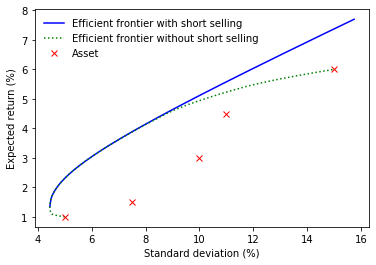

In [6]:
fig1 = plt.figure(num=1, facecolor='w')
plt.plot(sigma_p, mu_p_efficient, 'b-', label='Efficient frontier with short selling')
plt.plot(V_Risk, V_Target, 'g:', label='Efficient frontier without short selling')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'rx', label='Asset')
plt.legend(loc='best',  frameon=False)
plt.xlabel('Standard deviation (%)')
plt.ylabel('Expected return (%)')
plt.show()

Here we plot opitimal allocation weights.

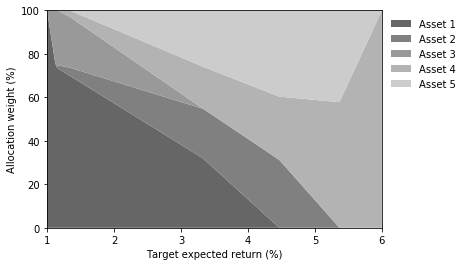

In [7]:
fig2 = plt.figure(num=2, facecolor='w')
plt.stackplot(V_Target, V_Weight.T*100,
              colors=tuple([tuple(gray*np.ones(3)) for gray in np.linspace(0.4, 0.8, num=Mu.shape[0])]))
plt.axis([Mu.min(), Mu.max(), 0.0, 100.0])
plt.legend(['Asset 1', 'Asset 2', 'Asset 3', 'Asset 4', 'Asset 5'],
           loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)
plt.xlabel('Target expected return (%)')
plt.ylabel('Allocation weight (%)')
plt.show()